In [ ]:
import pandas as pd
import requests
import seaborn as sns

sns.set_theme(palette="deep")


In [ ]:
from io import BytesIO
from urllib.parse import urlencode

base_url = "anonymized"
public_key = "anonymized"

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()["href"]
response = requests.get(download_url)

path_to_dataset = "data"  # Choose any appropriate local path


parquet_file = BytesIO(response.content)
df = pd.read_parquet(parquet_file, engine="pyarrow")  # or engine='fastparquet'

# zipfile = ZipFile(BytesIO(response.content))
# zipfile.extractall(path=path_to_dataset)

In [3]:
mmlu_entropy_df = df
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,qwen2_ans_correct,qwen2_entropies,qwen2_every_token_info,qwen2_ans_token_index,qwen2_response,qwen2_input_embeddings,qwen2_think_embeddings,qwen2_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.5892512798309326, 1.3297805786132812, 0.301...","[[{""token_idx"": 785, ""token_prob"": 2.320308522...",306,"To address this question, let's analyze each o...","{""min"": [-5.5, -7.375, -8.625, -5.1875, -7.343...","{""min"": [-5.5625, -3.984375, -5.46875, -5.2187...","{""min"": [2.25, -1.609375, -0.1298828125, -0.30..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,False,"[0.06377062201499939, 0.2561260163784027, 0.00...","[[{""token_idx"": 641, ""token_prob"": 0.000177708...",365,To determine which of these articles are not q...,"{""min"": [-5.71875, -7.71875, -9.0625, -4.96875...","{""min"": [-4.4375, -3.65625, -6.21875, -6.03125...","{""min"": [2.1875, -1.6875, 0.1533203125, -0.261..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7012186646461487, 1.7263343334197998, 0.152...","[[{""token_idx"": 785, ""token_prob"": 0.004308272...",351,To determine the correct term for ensuring tha...,"{""min"": [-5.28125, -7.96875, -8.0625, -6.5625,...","{""min"": [-5.5, -5.40625, -4.15625, -5.71875, -...","{""min"": [2.015625, -1.34375, -0.46484375, 0.06..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.33975401520729065, 1.217799186706543, 0.254...","[[{""token_idx"": 641, ""token_prob"": 1.505114141...",362,"To solve this problem, we need to calculate th...","{""min"": [-5.21875, -7.96875, -8.75, -5.4375, -...","{""min"": [-5.34375, -8.25, -5.125, -7.125, -5.4...","{""min"": [2.125, 0.072265625, -0.373046875, 0.4..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,False,"[0.23145945370197296, 0.8183579444885254, 0.26...","[[{""token_idx"": 1249, ""token_prob"": 0.93947321...",289,"To solve this problem, we need to work backwar...","{""min"": [-5.21875, -7.96875, -8.75, -6.46875, ...","{""min"": [-5.84375, -4.625, -3.828125, -5.1875,...","{""min"": [2.75, -1.9140625, -0.248046875, -0.60..."


In [4]:
mmlu_entropy_df.value_counts("qwen2_ans_token_index", dropna=False)

qwen2_ans_token_index
-1       842
 438      47
 447      45
 347      42
 429      42
        ... 
 786       1
 766       1
 723       1
 185       1
 1022      1
Length: 899, dtype: int64

In [5]:
# Filter out unanswered questions (qwen2_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["qwen2_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 11190 after filtering


In [ ]:
def entropy_counter(arr):
    sum = 0
    for i in arr:
        sum -= i["token_prob"] * np.log(i["token_prob"])
    return sum

In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np


def extract_cot_answer_from_row(tokenizer, row, column_every_token_info, column_ans_token_index):
    every_token_info = json.loads(row[column_every_token_info])
    answer_token_probs = every_token_info[row[column_ans_token_index]]

    max_prob_idx = np.argmax([item["token_prob"] for item in answer_token_probs])
    answer_token = answer_token_probs[max_prob_idx]["token_idx"]
    return tokenizer.decode(answer_token)


def extract_cot_answer_entropy_from_row(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    return answer_token_entropy


def visualize_entropy_all(df, x, hue, model_name=None):
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="dodge",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
    plt.legend(
        handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer", loc="upper right"
    )
    if model_name is not None:
        plt.title(model_name)
    # plt.savefig("entropy_phi4.pdf")

    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="fill",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Proportion")
    plt.legend(handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer")
    if model_name is not None:
        plt.title(model_name)


In [10]:
import ast

len(ast.literal_eval(mmlu_entropy_df_filtered.qwen2_entropies.iloc[0]))

309

In [11]:
from transformers import AutoTokenizer

# from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["qwen2_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "qwen2_every_token_info", "qwen2_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["qwen2_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-05-19 09:35:31.454107: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 09:35:33.192915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 09:35:39.794080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_10225/159539326

In [ ]:
[
    tokenizer.encode(".\n\n"),
    tokenizer.encode(".\n"),
    tokenizer.encode("\n"),
    tokenizer.encode("\n\n"),
    tokenizer.encode(":\n\n"),
    tokenizer.encode(":\n"),
    tokenizer.encode("]\n"),
    tokenizer.encode("]\n\n"),
    tokenizer.encode(";\n\n"),
    tokenizer.encode(";\n"),
    tokenizer.encode(";"),
    tokenizer.encode("..."),
    tokenizer.encode("**\n\n"),
    tokenizer.encode("**\n"),
    tokenizer.encode("*\n\n"),
    tokenizer.encode("*\n"),
]

[[382],
 [624],
 [198],
 [271],
 [1447],
 [510],
 [921],
 [2533],
 [401],
 [280],
 [26],
 [1112],
 [56177],
 [1019],
 [21518],
 [5618]]

In [13]:
tokenizer.decode(151645)

'<|im_end|>'

In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        maxi = 0
        maxii = 0
        for i in sublist:
            if i["token_prob"] > maxi:
                maxii = maxi
                maxi = i["token_prob"]
        prob_max.append(1 - (maxi - maxii))
    return np.mean(prob_max)
    # return


mmlu_entropy_df_filtered["qwen2_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)

/tmp/ipykernel_10225/1951512631.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(np.max([item["token_prob"] for item in sublist]))

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["qwen2_max_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)


def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(sublist[np.argmax([item["token_prob"] for item in sublist])]["token_idx"])

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["qwen2_argmax_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)

/tmp/ipykernel_10225/2994128280.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_max_prob"] = mmlu_entropy_df_filtered.apply(
/tmp/ipykernel_10225/2994128280.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_argmax_prob"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.mean([ind for ind in entropies])


mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/tmp/ipykernel_10225/4177692007.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.max([ind for ind in entropies])


mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)

/tmp/ipykernel_10225/505312814.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    # return np.mean([ind for ind in entropies])
    return np.abs(np.max([ind for ind in entropies]) - answer_token_entropy)


mmlu_entropy_df_filtered["qwen2_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/tmp/ipykernel_10225/3911279233.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # ev = json.loads(row[every])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    top1, top2 = sorted(entropies, reverse=True)[:2]

    return abs(top1 - top2)
    # why = np.argmax([ind['token_prob'] for ind in ast.literal_eval(row[every])[check]])

    # piv = ast.literal_eval(mmlu_entropy_df_filtered.qwen2_every_token_info.iloc[ran])[check][why]['token_idx']


mmlu_entropy_df_filtered["qwen2_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/tmp/ipykernel_10225/4161705903.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(


In [21]:
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import roc_auc_score


def normalize_score(column):
    return 1 - column / column.max()


@dataclass
class ROC_AUC:
    roc_auc: float
    gini: float


def calculate_roc_auc(y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    gini = abs(2 * roc_auc - 1)
    return ROC_AUC(roc_auc=roc_auc, gini=gini)


def calculate_accuracy(df, model_answer_correct_col):
    return df[model_answer_correct_col].sum() / len(df)


def calculate_roc_auc_by_category(df, model_name, category_col, model_answer_correct_col, score_col, threshold=10):
    results = []

    roc_auc = calculate_roc_auc(df[model_answer_correct_col], normalize_score(df[score_col]))

    results.append(
        {
            "category": "ALL",
            "roc_auc": roc_auc.roc_auc,
            "gini": roc_auc.gini,
            "num_samples": len(df),
            "accuracy": calculate_accuracy(df, model_answer_correct_col),
            "model": model_name,
            "metric": score_col,
        }
    )

    for category in df[category_col].unique():
        df_cat = df[df[category_col] == category]
        if len(df_cat) < threshold:
            continue

        roc_auc = calculate_roc_auc(df_cat[model_answer_correct_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": roc_auc.roc_auc,
                "gini": roc_auc.gini,
                "num_samples": len(df_cat),
                "accuracy": calculate_accuracy(df_cat, model_answer_correct_col),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)

In [ ]:
option_ids = [str(i + 1) for i in range(20)]
# 0 is a special exception for "do not know"
option_ids_w_fallback = option_ids + ["0"]


def validate_mmlu_answer(answer):
    return str(answer) in option_ids_w_fallback


def keep_only_valid_and_known_answers(df, column_name, option_ids=option_ids):
    return df[df[column_name].isin(option_ids)]

In [23]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
# from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "qwen2_answer")

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

qwen2_answer
1         2361
3         1667
2         1214
4         1157
7         1126
5          925
6          830
8          801
9          643
0          461
A            1
False        1
b            1
h            1
number       1
dtype: int64
qwen2_answer
1    2361
3    1667
2    1214
4    1157
7    1126
5     925
6     830
8     801
9     643
dtype: int64


In [24]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,qwen2_ans_correct,qwen2_entropies,qwen2_every_token_info,qwen2_ans_token_index,qwen2_response,qwen2_input_embeddings,qwen2_think_embeddings,qwen2_answer_embeddings,qwen2_answer,qwen2_answer_entropy,qwen2_prob_diff_ent,qwen2_max_prob,qwen2_argmax_prob,qwen2_answer_entropy_cot_mean,qwen2_answer_entropy_cot_max,qwen2_answer_entropy_marg,qwen2_answer_entropy_top_diff,qwen2_answer_entropy_sequence_mean
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.5892512798309326, 1.3297805786132812, 0.301...","[[{""token_idx"": 785, ""token_prob"": 2.320308522...",306,"To address this question, let's analyze each o...","{""min"": [-5.5, -7.375, -8.625, -5.1875, -7.343...","{""min"": [-5.5625, -3.984375, -5.46875, -5.2187...","{""min"": [2.25, -1.609375, -0.1298828125, -0.30...",3,0.000387,0.328957,"[0.7304577827453613, 0.649590253829956, 0.9142...","[1249, 2621, 419, 3405, 11, 1077, 594, 23643, ...",0.966237,3.978779,3.978392,0.131620,0.625949
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,False,"[0.06377062201499939, 0.2561260163784027, 0.00...","[[{""token_idx"": 641, ""token_prob"": 0.000177708...",365,To determine which of these articles are not q...,"{""min"": [-5.71875, -7.71875, -9.0625, -4.96875...","{""min"": [-4.4375, -3.65625, -6.21875, -6.03125...","{""min"": [2.1875, -1.6875, 0.1533203125, -0.261...",4,0.808208,0.378075,"[0.9896883964538574, 0.9546421766281128, 0.998...","[1249, 8253, 892, 315, 1493, 9709, 525, 537, 1...",1.072014,3.632082,2.823874,0.000628,0.980800
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7012186646461487, 1.7263343334197998, 0.152...","[[{""token_idx"": 785, ""token_prob"": 0.004308272...",351,To determine the correct term for ensuring tha...,"{""min"": [-5.28125, -7.96875, -8.0625, -6.5625,...","{""min"": [-5.5, -5.40625, -4.15625, -5.71875, -...","{""min"": [2.015625, -1.34375, -0.46484375, 0.06...",2,0.002817,0.390763,"[0.6705873608589172, 0.4496406316757202, 0.969...","[1249, 8253, 279, 4396, 4647, 369, 22573, 429,...",1.098229,3.156420,3.153603,0.034503,1.088550
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.33975401520729065, 1.217799186706543, 0.254...","[[{""token_idx"": 641, ""token_prob"": 1.505114141...",362,"To solve this problem, we need to calculate th...","{""min"": [-5.21875, -7.96875, -8.75, -5.4375, -...","{""min"": [-5.34375, -8.25, -5.125, -7.125, -5.4...","{""min"": [2.125, 0.072265625, -0.373046875, 0.4...",1,0.614686,0.179492,"[0.9011741876602173, 0.40966448187828064, 0.94...","[1249, 11625, 419, 3491, 11, 582, 1184, 311, 1...",0.459934,3.589844,2.975158,0.113288,0.397682
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,False,"[0.23145945370197296, 0.8183579444885254, 0.26...","[[{""token_idx"": 1249, ""token_prob"": 0.93947321...",289,"To solve this problem, we need to work backwar...","{""min"": [-5.21875, -7.96875, -8.75, -6.46875, ...","{""min"": [-5.84375, -4.625, -3.828125, -5.1875,...","{""min"": [2.75, -1.9140625, -0.248046875, -0.60...",5,0.008047,0.130437,"[0.9394732117652893, 0.6905720233917236, 0.934...","[1249, 11625, 419, 3491, 11, 582, 1184, 311, 9...",0.258844,2.440197,2.432150,0.279467,0.416543
...,.

<h2>Sequence mean entropy<h2>

/tmp/ipykernel_10225/3792165459.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_mean"] = mmlu_entropy_df_filtered.apply(


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.585943,0.171885,10724,0.409735,Qwen-3b,qwen2_answer_entropy_sequence_mean
1,law,0.514113,0.028226,1071,0.225023,Qwen-3b,qwen2_answer_entropy_sequence_mean
2,business,0.624027,0.248054,735,0.465306,Qwen-3b,qwen2_answer_entropy_sequence_mean
3,psychology,0.593009,0.186017,766,0.506527,Qwen-3b,qwen2_answer_entropy_sequence_mean
4,chemistry,0.649629,0.299257,925,0.390270,Qwen-3b,qwen2_answer_entropy_sequence_mean
5,biology,0.567683,0.135365,671,0.597615,Qwen-3b,qwen2_answer_entropy_sequence_mean
6,history,0.565957,0.131915,365,0.356164,Qwen-3b,qwen2_answer_entropy_sequence_mean
7,other,0.548516,0.097032,876,0.359589,Qwen-3b,qwen2_answer_entropy_sequence_mean
8,physics,0.605872,0.211744,1092,0.409341,Qwen-3b,qwen2_answer_entropy_sequence_mean
9,computer science,0.533730,0.067460,382,0.329843,Qwen-3b,qwen2_answer_entropy_sequence_mean


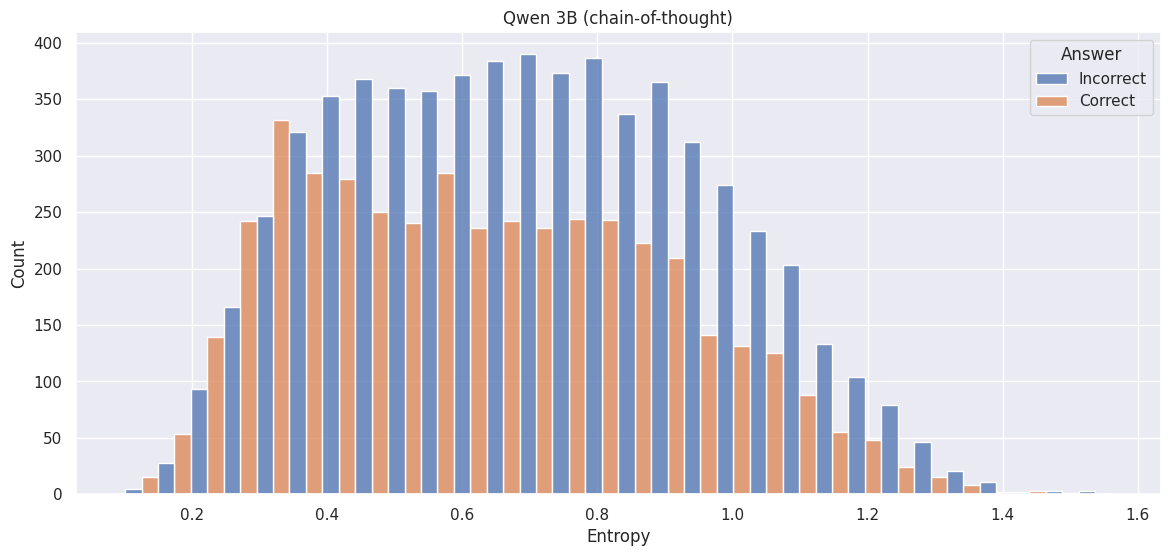

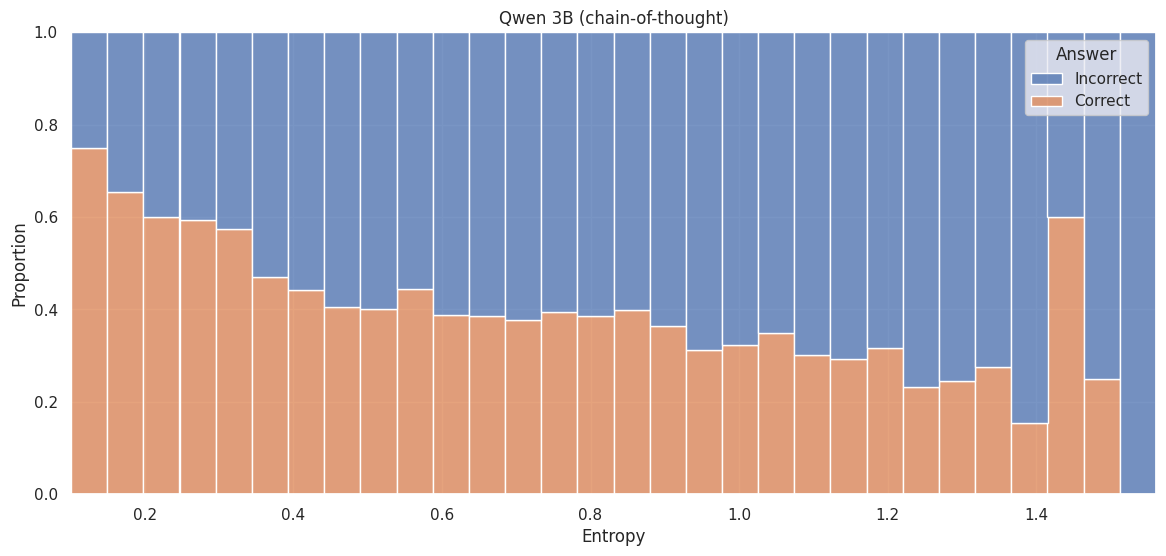

In [ ]:
splitters = [382, 624, 198, 271, 1447, 510, 921, 2533, 401, 280, 26, 1112, 56177, 1019, 21518, 5618, 151645]
name = "qwen2_answer_entropy_sequence_mean"


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    # print()
    # answer_token_entropy = entropies[row[column_ans_token_index]]

    # top1, top2 = sorted(entropies, reverse=True)[:2]
    entr = []
    seq_entr = []
    counter = 0
    # print(row[args])
    for sublist in row[args]:
        # prob_max = np.argmax([item['token_prob'] for item in sublist])
        entr.append(entropies[counter])
        # print(entr)
        if sublist in splitters:
            # print(entr)
            seq_entr.append(np.mean(entr))
            # print(np.mean(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_argmax_prob"), axis=1
)


visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence mean max entropy<h2>

/tmp/ipykernel_10225/964683426.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_mean_max"] = mmlu_entropy_df_filtered.apply(


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.600998,0.201996,10724,0.409735,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
1,law,0.522132,0.044263,1071,0.225023,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
2,business,0.606945,0.213889,735,0.465306,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
3,psychology,0.529441,0.058883,766,0.506527,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
4,chemistry,0.615106,0.230212,925,0.390270,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
5,biology,0.565364,0.130729,671,0.597615,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
6,history,0.568412,0.136825,365,0.356164,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
7,other,0.583442,0.166885,876,0.359589,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
8,physics,0.622954,0.245908,1092,0.409341,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
9,computer science,0.560299,0.120598,382,0.329843,Qwen-3b,qwen2_answer_entropy_sequence_mean_max


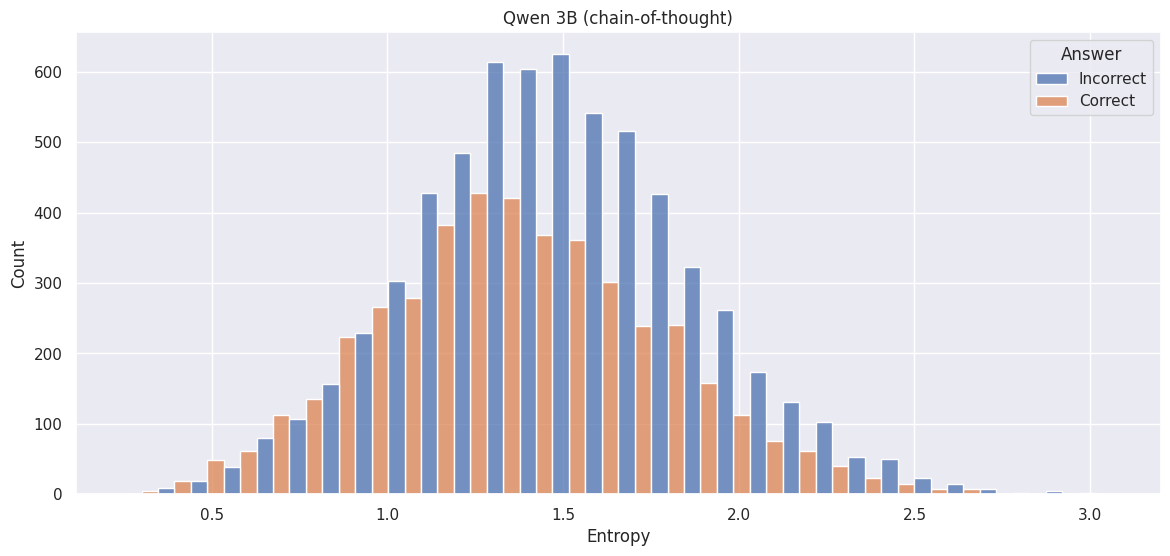

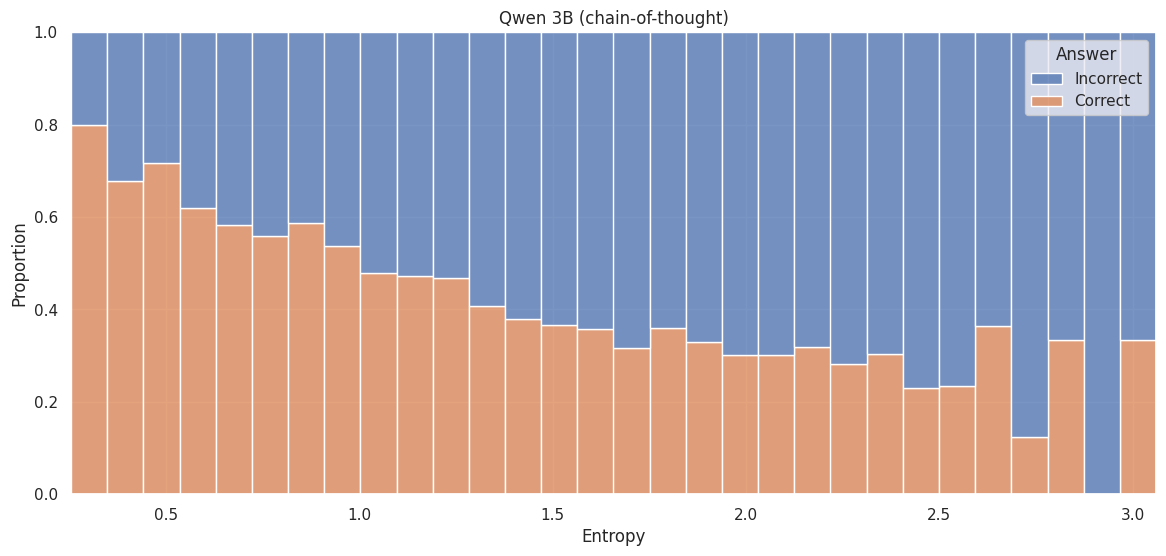

In [ ]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.mean(entr))

            entr = []
        counter += 1
    return np.max(seq_entr)


mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_mean_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_argmax_prob"), axis=1
)

name = "qwen2_answer_entropy_sequence_mean_max"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence max mean entropy<h2>

/tmp/ipykernel_10225/2746753345.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_max_mean"] = mmlu_entropy_df_filtered.apply(


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.581264,0.162527,10724,0.409735,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
1,law,0.508254,0.016508,1071,0.225023,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
2,business,0.630865,0.261729,735,0.465306,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
3,psychology,0.597304,0.194608,766,0.506527,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
4,chemistry,0.639437,0.278875,925,0.390270,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
5,biology,0.554807,0.109615,671,0.597615,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
6,history,0.573748,0.147496,365,0.356164,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
7,other,0.539371,0.078743,876,0.359589,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
8,physics,0.602601,0.205203,1092,0.409341,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
9,computer science,0.511843,0.023686,382,0.329843,Qwen-3b,qwen2_answer_entropy_sequence_max_mean


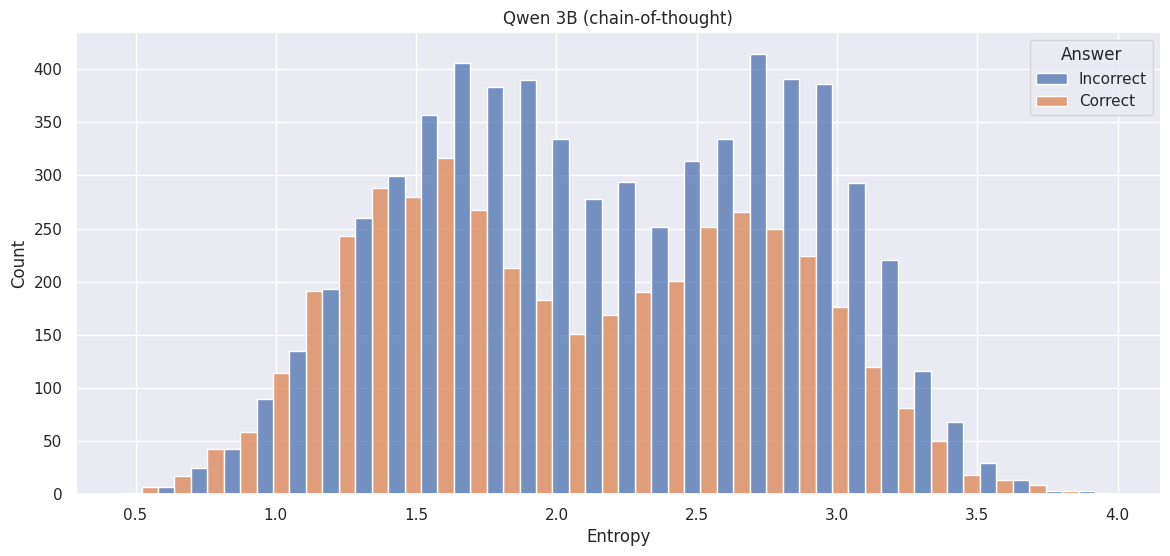

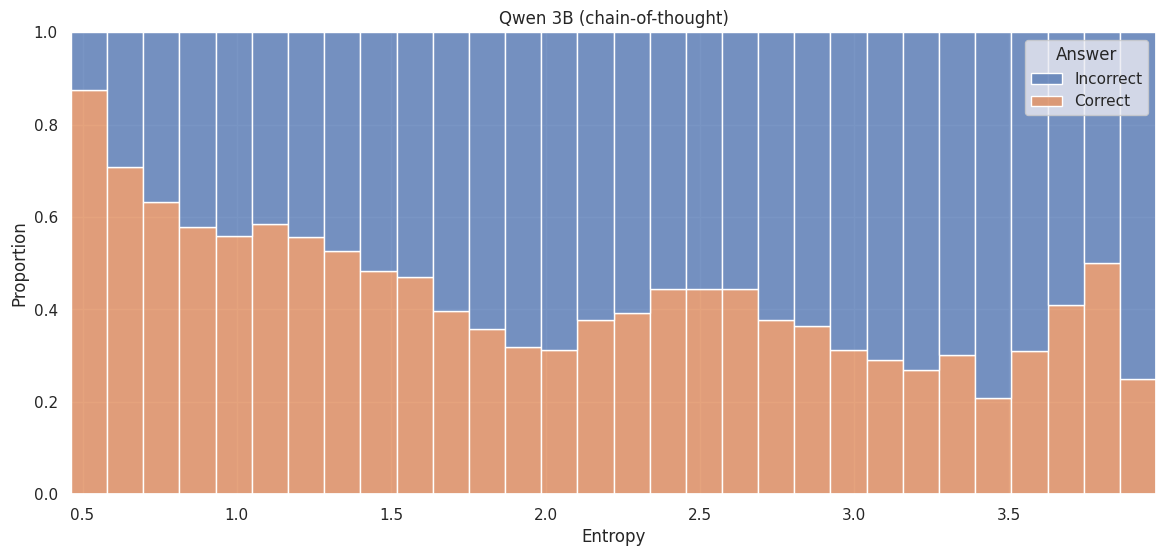

In [ ]:
splitters = [382, 624, 198, 271, 1447, 510, 921, 2533, 401, 280, 26, 1112, 56177, 1019, 21518, 5618, 151645]


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.max(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_max_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_argmax_prob"), axis=1
)

name = "qwen2_answer_entropy_sequence_max_mean"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


In [28]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,qwen2_ans_correct,qwen2_entropies,qwen2_every_token_info,qwen2_ans_token_index,qwen2_response,qwen2_input_embeddings,qwen2_think_embeddings,qwen2_answer_embeddings,qwen2_answer,qwen2_answer_entropy,qwen2_prob_diff_ent,qwen2_max_prob,qwen2_argmax_prob,qwen2_answer_entropy_cot_mean,qwen2_answer_entropy_cot_max,qwen2_answer_entropy_marg,qwen2_answer_entropy_top_diff,qwen2_answer_entropy_sequence_mean,qwen2_answer_entropy_sequence_mean_max,qwen2_answer_entropy_sequence_max_mean
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.5892512798309326, 1.3297805786132812, 0.301...","[[{""token_idx"": 785, ""token_prob"": 2.320308522...",306,"To address this question, let's analyze each o...","{""min"": [-5.5, -7.375, -8.625, -5.1875, -7.343...","{""min"": [-5.5625, -3.984375, -5.46875, -5.2187...","{""min"": [2.25, -1.609375, -0.1298828125, -0.30...",3,0.000387,0.328957,"[0.7304577827453613, 0.649590253829956, 0.9142...","[1249, 2621, 419, 3405, 11, 1077, 594, 23643, ...",0.966237,3.978779,3.978392,0.131620,0.625949,1.455126,1.898943
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,False,"[0.06377062201499939, 0.2561260163784027, 0.00...","[[{""token_idx"": 641, ""token_prob"": 0.000177708...",365,To determine which of these articles are not q...,"{""min"": [-5.71875, -7.71875, -9.0625, -4.96875...","{""min"": [-4.4375, -3.65625, -6.21875, -6.03125...","{""min"": [2.1875, -1.6875, 0.1533203125, -0.261...",4,0.808208,0.378075,"[0.9896883964538574, 0.9546421766281128, 0.998...","[1249, 8253, 892, 315, 1493, 9709, 525, 537, 1...",1.072014,3.632082,2.823874,0.000628,0.980800,1.610026,2.758251
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7012186646461487, 1.7263343334197998, 0.152...","[[{""token_idx"": 785, ""token_prob"": 0.004308272...",351,To determine the correct term for ensuring tha...,"{""min"": [-5.28125, -7.96875, -8.0625, -6.5625,...","{""min"": [-5.5, -5.40625, -4.15625, -5.71875, -...","{""min"": [2.015625, -1.34375, -0.46484375, 0.06...",2,0.002817,0.390763,"[0.6705873608589172, 0.4496406316757202, 0.969...","[1249, 8253, 279, 4396, 4647, 369, 22573, 429,...",1.098229,3.156420,3.153603,0.034503,1.088550,1.318161,2.749959
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.33975401520729065, 1.217799186706543, 0.254...","[[{""token_idx"": 641, ""token_prob"": 1.505114141...",362,"To solve this problem, we need to calculate th...","{""min"": [-5.21875, -7.96875, -8.75, -5.4375, -...","{""min"": [-5.34375, -8.25, -5.125, -7.125, -5.4...","{""min"": [2.125, 0.072265625, -0.373046875, 0.4...",1,0.614686,0.179492,"[0.9011741876602173, 0.40966448187828064, 0.94...","[1249, 11625, 419, 3491, 11, 582, 1184, 311, 1...",0.459934,3.589844,2.975158,0.113288,0.397682,1.185002,1.290784
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,False,"[0.23145945370197296, 0.8183579444885254, 0.26...","[[{""token_idx"": 1249, ""token_prob"": 0.93947321...",289,"To solve this problem, we need to work backwar...","{""min"": [-5.21875, -7.96875, -8.75, -6.46875, ...","{""min"": [-5.84375, -4.625, -3.828125, -5.1875,...","{""min"": [2.75, -1.9140625, -0.248046875, -0.60...",5,0.008047,0.130437,"[0.

<h2>Entropy of Answer<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.669159,0.338317,10724,0.409735,Qwen-3b,qwen2_answer_entropy
1,law,0.572629,0.145258,1071,0.225023,Qwen-3b,qwen2_answer_entropy
2,business,0.674315,0.348630,735,0.465306,Qwen-3b,qwen2_answer_entropy
3,psychology,0.696647,0.393294,766,0.506527,Qwen-3b,qwen2_answer_entropy
4,chemistry,0.681416,0.362832,925,0.390270,Qwen-3b,qwen2_answer_entropy
5,biology,0.677676,0.355352,671,0.597615,Qwen-3b,qwen2_answer_entropy
6,history,0.609591,0.219182,365,0.356164,Qwen-3b,qwen2_answer_entropy
7,other,0.627400,0.254800,876,0.359589,Qwen-3b,qwen2_answer_entropy
8,physics,0.670541,0.341082,1092,0.409341,Qwen-3b,qwen2_answer_entropy
9,computer science,0.731709,0.463418,382,0.329843,Qwen-3b,qwen2_answer_entropy


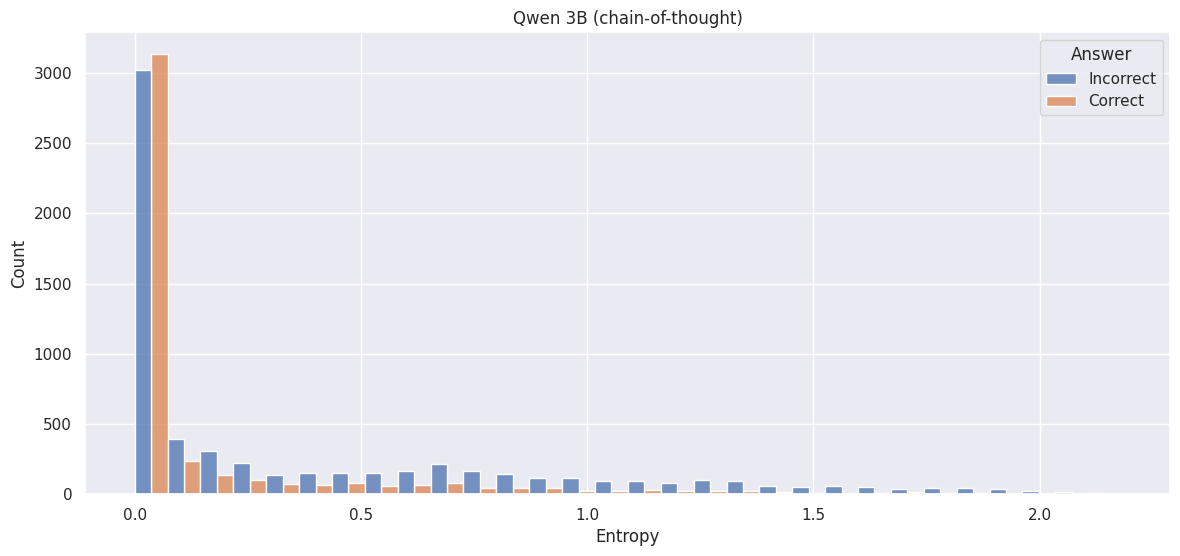

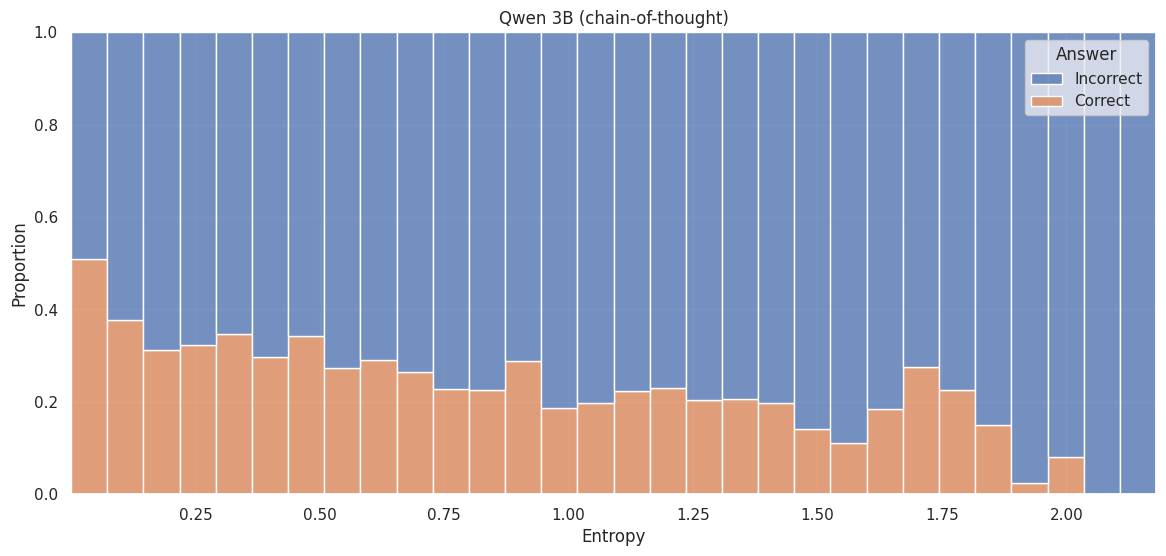

In [29]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "qwen2_answer_entropy", "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy",
    model_name=model_title,
)
roc_auc_res

<h2>COT max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.613288,0.226576,10724,0.409735,Qwen-3b,qwen2_answer_entropy_cot_max
1,law,0.463183,0.073634,1071,0.225023,Qwen-3b,qwen2_answer_entropy_cot_max
2,business,0.655261,0.310522,735,0.465306,Qwen-3b,qwen2_answer_entropy_cot_max
3,psychology,0.573767,0.147535,766,0.506527,Qwen-3b,qwen2_answer_entropy_cot_max
4,chemistry,0.678091,0.356182,925,0.390270,Qwen-3b,qwen2_answer_entropy_cot_max
5,biology,0.599206,0.198411,671,0.597615,Qwen-3b,qwen2_answer_entropy_cot_max
6,history,0.557152,0.114304,365,0.356164,Qwen-3b,qwen2_answer_entropy_cot_max
7,other,0.572068,0.144136,876,0.359589,Qwen-3b,qwen2_answer_entropy_cot_max
8,physics,0.640289,0.280579,1092,0.409341,Qwen-3b,qwen2_answer_entropy_cot_max
9,computer science,0.572576,0.145151,382,0.329843,Qwen-3b,qwen2_answer_entropy_cot_max


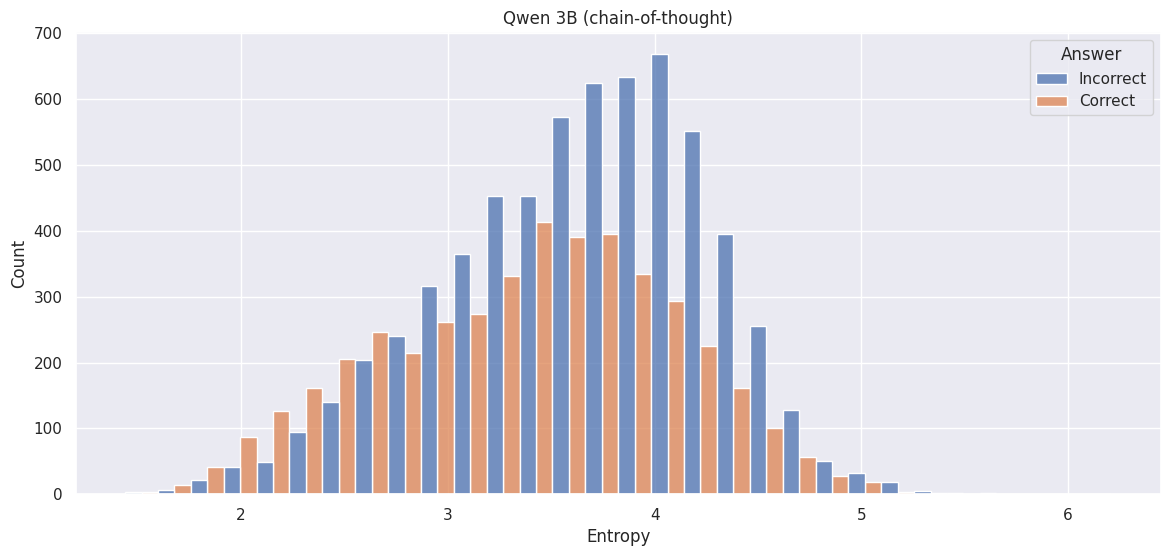

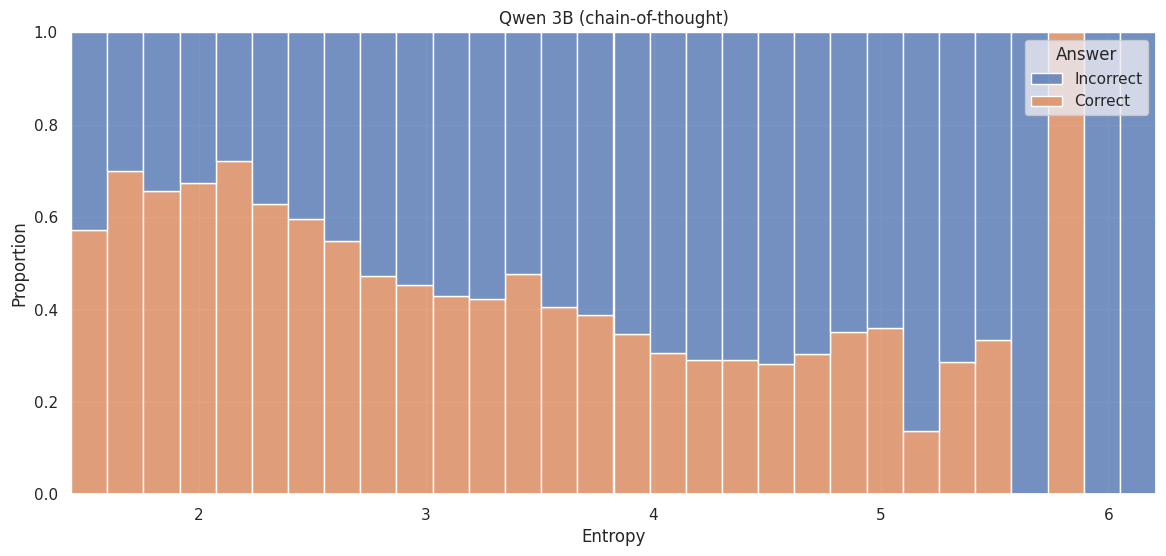

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "qwen2_answer_entropy_cot_max",
    "qwen2_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_cot_max",
    model_name=model_title,
)
roc_auc_res


<h2>COT mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.578852,0.157705,10724,0.409735,Qwen-3b,qwen2_answer_entropy_cot_mean
1,law,0.494516,0.010968,1071,0.225023,Qwen-3b,qwen2_answer_entropy_cot_mean
2,business,0.633231,0.266461,735,0.465306,Qwen-3b,qwen2_answer_entropy_cot_mean
3,psychology,0.596752,0.193504,766,0.506527,Qwen-3b,qwen2_answer_entropy_cot_mean
4,chemistry,0.644295,0.288590,925,0.390270,Qwen-3b,qwen2_answer_entropy_cot_mean
5,biology,0.577464,0.154927,671,0.597615,Qwen-3b,qwen2_answer_entropy_cot_mean
6,history,0.546939,0.093879,365,0.356164,Qwen-3b,qwen2_answer_entropy_cot_mean
7,other,0.537606,0.075211,876,0.359589,Qwen-3b,qwen2_answer_entropy_cot_mean
8,physics,0.599903,0.199806,1092,0.409341,Qwen-3b,qwen2_answer_entropy_cot_mean
9,computer science,0.541729,0.083457,382,0.329843,Qwen-3b,qwen2_answer_entropy_cot_mean


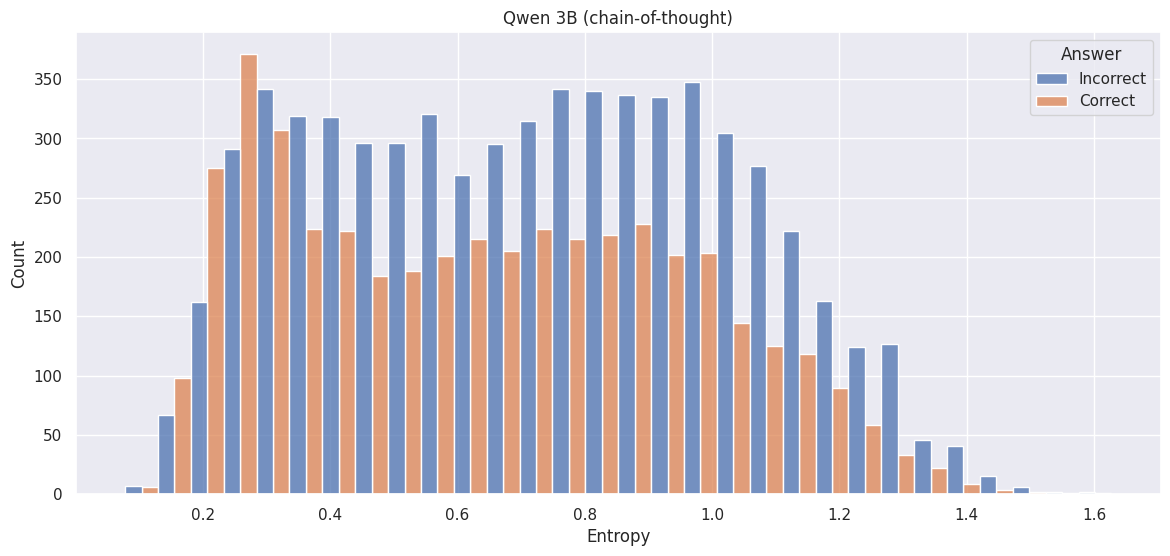

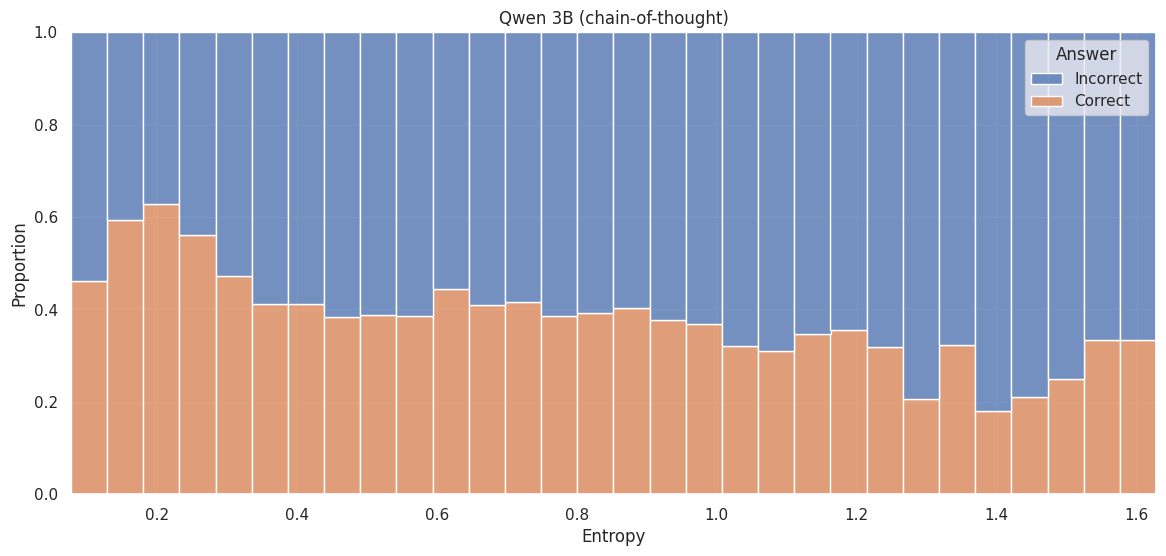

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "qwen2_answer_entropy_cot_mean",
    "qwen2_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_cot_mean",
    model_name=model_title,
)
roc_auc_res


<h2>Max COT entropy and answer entropy difference<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.528311,0.056622,10724,0.409735,Qwen-3b,qwen2_answer_entropy_marg
1,law,0.439869,0.120262,1071,0.225023,Qwen-3b,qwen2_answer_entropy_marg
2,business,0.567527,0.135053,735,0.465306,Qwen-3b,qwen2_answer_entropy_marg
3,psychology,0.481713,0.036573,766,0.506527,Qwen-3b,qwen2_answer_entropy_marg
4,chemistry,0.518929,0.037858,925,0.390270,Qwen-3b,qwen2_answer_entropy_marg
5,biology,0.520680,0.041360,671,0.597615,Qwen-3b,qwen2_answer_entropy_marg
6,history,0.514501,0.029002,365,0.356164,Qwen-3b,qwen2_answer_entropy_marg
7,other,0.504015,0.008030,876,0.359589,Qwen-3b,qwen2_answer_entropy_marg
8,physics,0.523178,0.046356,1092,0.409341,Qwen-3b,qwen2_answer_entropy_marg
9,computer science,0.439484,0.121032,382,0.329843,Qwen-3b,qwen2_answer_entropy_marg


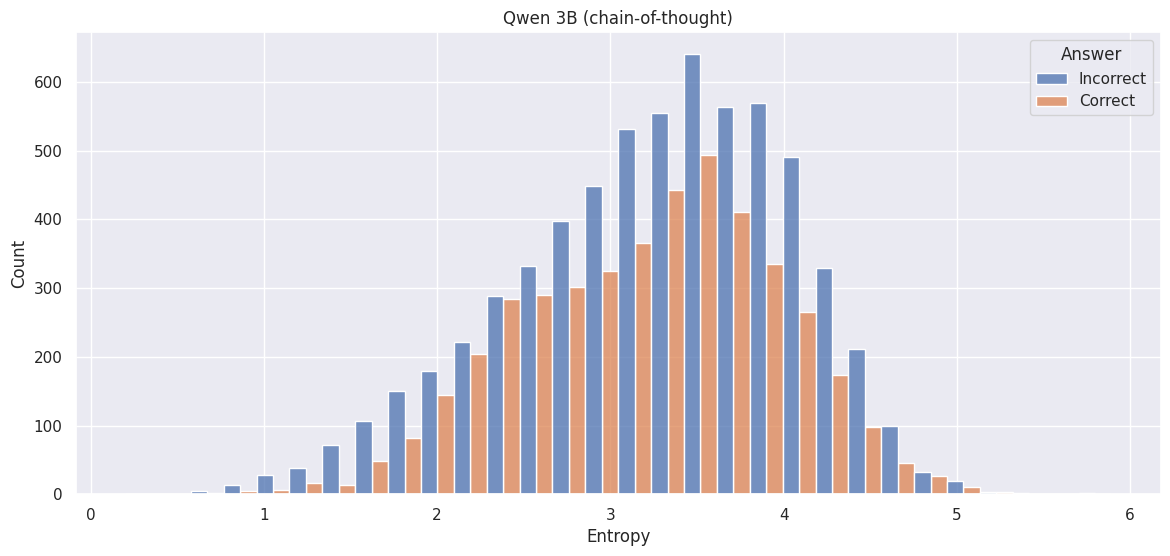

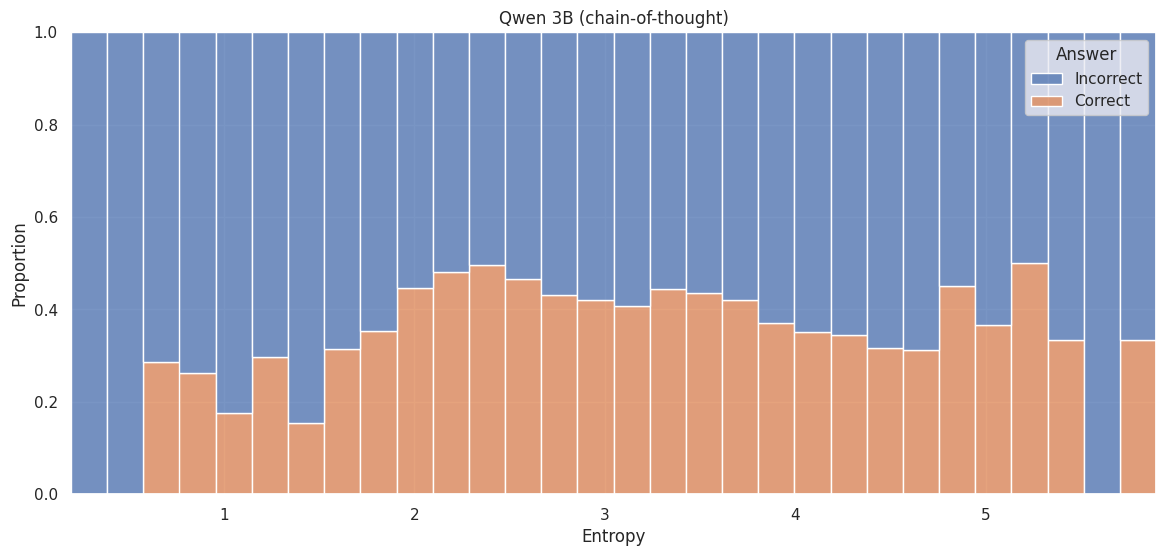

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "qwen2_answer_entropy_marg", "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_marg",
    model_name=model_title,
)
roc_auc_res

<h2>Mean of Marginal difference of 2 highest probs for each token<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.571540,0.143081,10724,0.409735,Qwen-3b,qwen2_prob_diff_ent
1,law,0.495446,0.009109,1071,0.225023,Qwen-3b,qwen2_prob_diff_ent
2,business,0.619987,0.239974,735,0.465306,Qwen-3b,qwen2_prob_diff_ent
3,psychology,0.586197,0.172394,766,0.506527,Qwen-3b,qwen2_prob_diff_ent
4,chemistry,0.637198,0.274395,925,0.390270,Qwen-3b,qwen2_prob_diff_ent
5,biology,0.572356,0.144712,671,0.597615,Qwen-3b,qwen2_prob_diff_ent
6,history,0.525041,0.050082,365,0.356164,Qwen-3b,qwen2_prob_diff_ent
7,other,0.525309,0.050618,876,0.359589,Qwen-3b,qwen2_prob_diff_ent
8,physics,0.591339,0.182679,1092,0.409341,Qwen-3b,qwen2_prob_diff_ent
9,computer science,0.533947,0.067894,382,0.329843,Qwen-3b,qwen2_prob_diff_ent


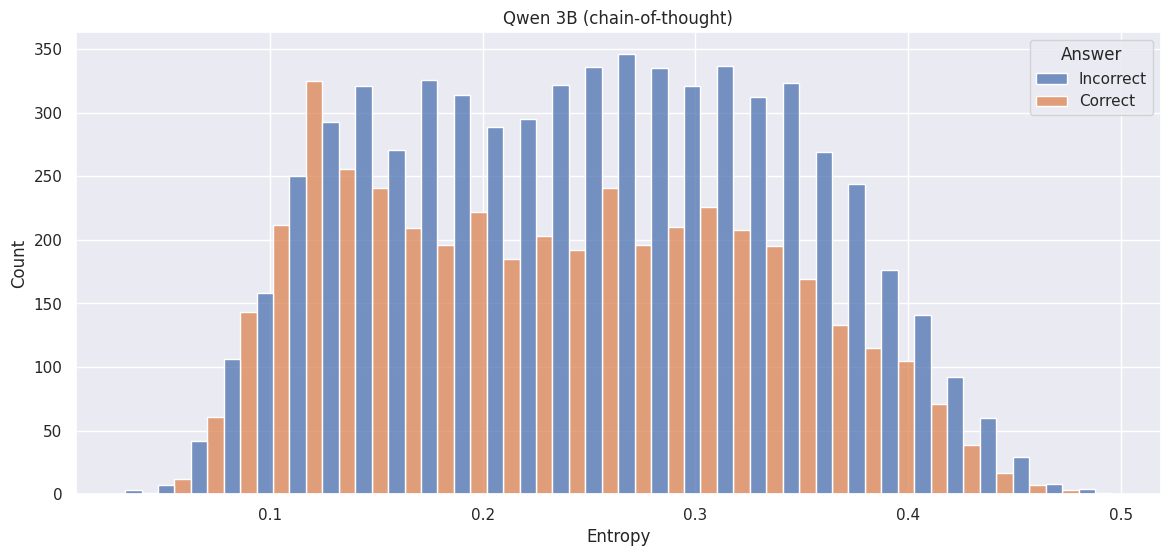

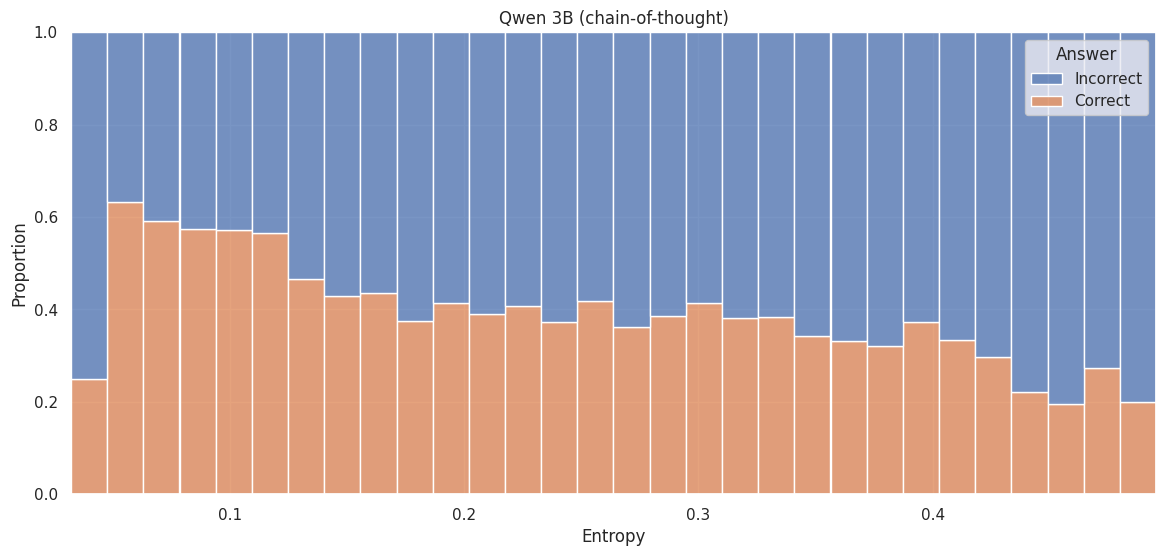

In [33]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "qwen2_prob_diff_ent", "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_prob_diff_ent",
    model_name=model_title,
)
roc_auc_res


<h2>Answer Entropy and Max COT mixed<h2>

/tmp/ipykernel_10225/1579047751.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered[name] = mmlu_entropy_df_filtered.apply(


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.686254,0.372508,10724,0.409735,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
1,law,0.553237,0.106474,1071,0.225023,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
2,business,0.707148,0.414297,735,0.465306,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
3,psychology,0.699490,0.398980,766,0.506527,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
4,chemistry,0.719490,0.438980,925,0.390270,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
5,biology,0.673307,0.346615,671,0.597615,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
6,history,0.607300,0.214599,365,0.356164,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
7,other,0.643132,0.286263,876,0.359589,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
8,physics,0.698448,0.396896,1092,0.409341,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
9,computer science,0.722935,0.445871,382,0.329843,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix


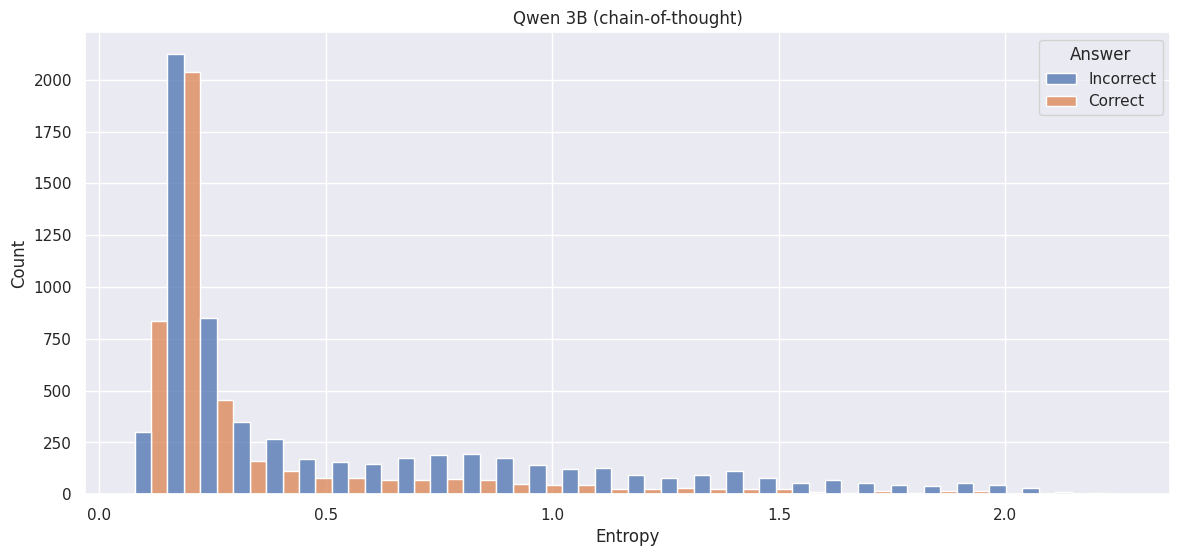

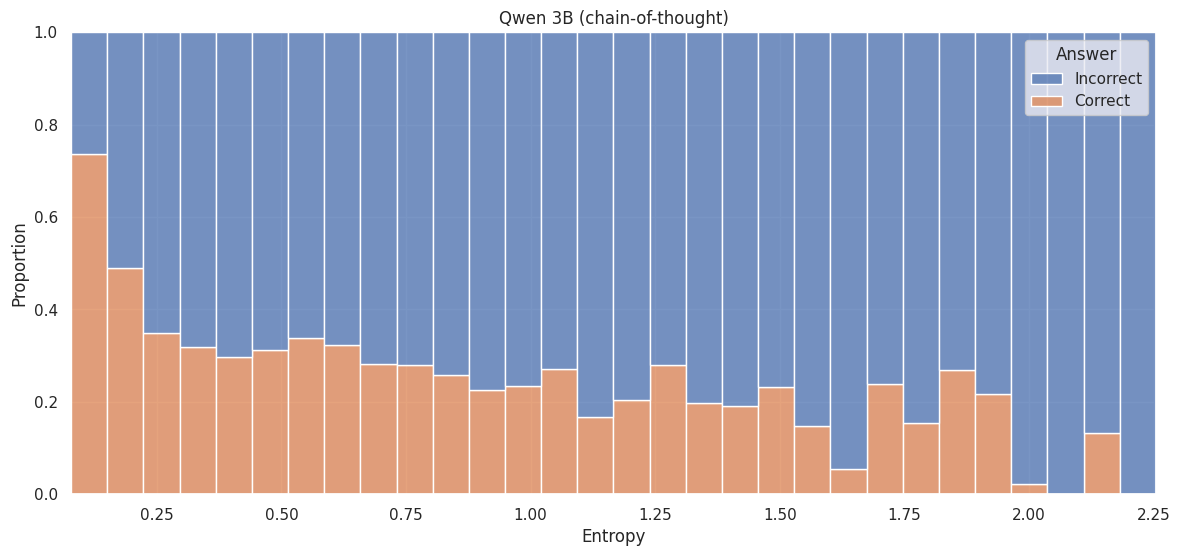

In [ ]:
name = "qwen2_answer_entropy_max_ans_entropy_mix"


def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    answer_token_entropy = entropies[row[column_ans_token_index]]
    return 0.05 * np.max([ind for ind in entropies]) + 0.95 * answer_token_entropy


mmlu_entropy_df_filtered[name] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Diff of 2 highest entropies<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.502007,0.004013,10724,0.409735,Qwen-3b,qwen2_answer_entropy_top_diff
1,law,0.473714,0.052572,1071,0.225023,Qwen-3b,qwen2_answer_entropy_top_diff
2,business,0.485023,0.029954,735,0.465306,Qwen-3b,qwen2_answer_entropy_top_diff
3,psychology,0.494641,0.010718,766,0.506527,Qwen-3b,qwen2_answer_entropy_top_diff
4,chemistry,0.536453,0.072906,925,0.390270,Qwen-3b,qwen2_answer_entropy_top_diff
5,biology,0.519128,0.038256,671,0.597615,Qwen-3b,qwen2_answer_entropy_top_diff
6,history,0.490802,0.018396,365,0.356164,Qwen-3b,qwen2_answer_entropy_top_diff
7,other,0.515870,0.031740,876,0.359589,Qwen-3b,qwen2_answer_entropy_top_diff
8,physics,0.503344,0.006687,1092,0.409341,Qwen-3b,qwen2_answer_entropy_top_diff
9,computer science,0.488312,0.023375,382,0.329843,Qwen-3b,qwen2_answer_entropy_top_diff


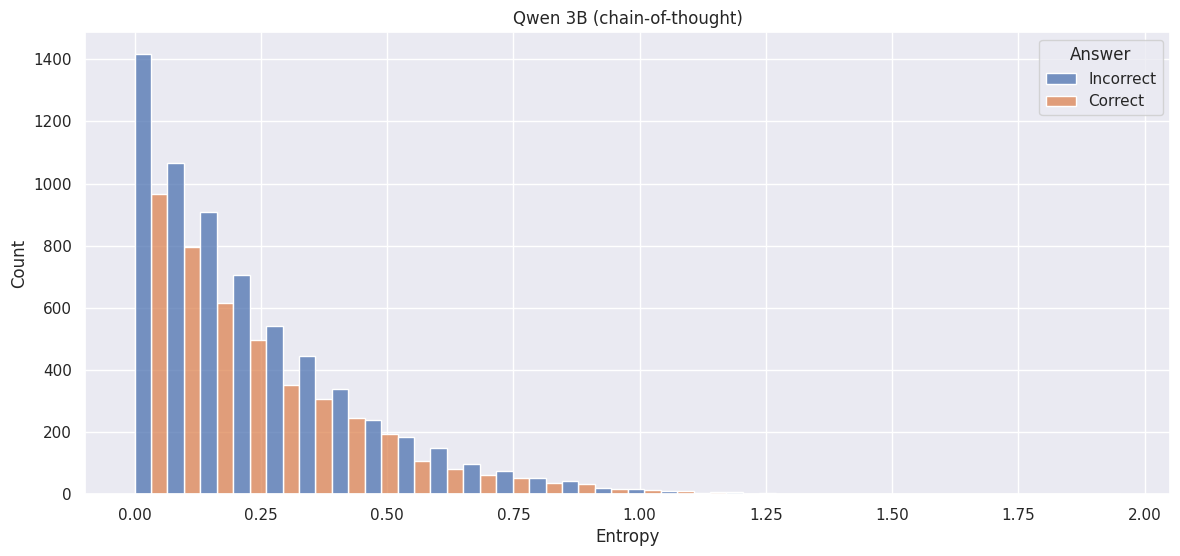

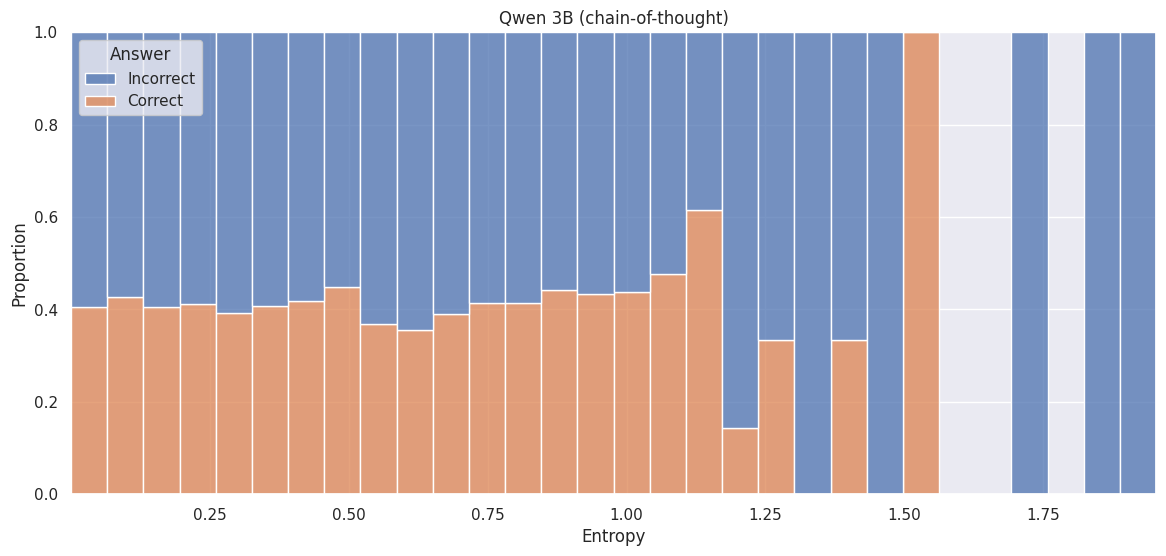

In [ ]:
# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "qwen2_answer_entropy_top_diff",
    "qwen2_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_top_diff",
    model_name=model_title,
)
roc_auc_res
